## New York Taxi Fare Prediction

In [1]:
# Connecting to Google drive
from google.colab import drive
drive.mount("/content/drive")

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
# Importing the necessary libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

import datetime
import math
import calendar
from geopy.geocoders import Nominatim
from sklearn.metrics.pairwise import haversine_distances

pd.options.display.max_columns = None
pd.set_option('display.max_rows', 500)
%matplotlib inline
matplotlib.rcParams["figure.figsize"] = (10,5)

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [30]:
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin

In [4]:
# Loading the dataset

path = "/content/drive/My Drive/Colab Datasets/NY Taxi Fare Prediction/taxi_fares_dataset_filtered.csv"
taxi_data = pd.read_csv(path)
taxi_data.head()

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,22.54,2015-06-21 21:46:34 UTC,-74.010483,40.717667,-73.985771,40.660366,1
1,58.00,2015-01-11 03:15:38 UTC,-73.983330,40.738720,-73.933197,40.847225,1
2,4.50,2015-03-12 08:08:38 UTC,-73.990173,40.756447,-73.985619,40.762829,1
3,11.50,2015-04-12 10:19:05 UTC,-73.979279,40.723438,-74.004608,40.746948,6
4,5.00,2015-05-12 23:51:42 UTC,-73.954796,40.779335,-73.944931,40.780087,1


In [5]:
taxi_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100001 entries, 0 to 100000
Data columns (total 7 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   fare_amount        100001 non-null  float64
 1   pickup_datetime    100001 non-null  object 
 2   pickup_longitude   100001 non-null  float64
 3   pickup_latitude    100001 non-null  float64
 4   dropoff_longitude  100001 non-null  float64
 5   dropoff_latitude   100001 non-null  float64
 6   passenger_count    100001 non-null  int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 5.3+ MB


##### There are 7 features from which "fare_amount" is the dependent feature and rest of them are independent features. There are no missing values present in the dataset.

### Feature Engineering

In [6]:
# Coverting the pickup datetime from UTC to NY Time 

taxi_data["pickup_datetime"] = pd.to_datetime(taxi_data["pickup_datetime"]) - datetime.timedelta(hours = 4)

In [7]:
# Extracting the datetime features

taxi_data["Year"] = taxi_data["pickup_datetime"].dt.year
taxi_data["Month"] = taxi_data["pickup_datetime"].dt.month
taxi_data["Day"] = taxi_data["pickup_datetime"].dt.day
taxi_data["Hour"] = taxi_data["pickup_datetime"].dt.hour
taxi_data["Minute"] = taxi_data["pickup_datetime"].dt.minute

In [8]:
# Categorical feature for Day and Night as the pickup might be , 0 for AM, and 1 for PM
taxi_data["Meridiem"] = np.where(taxi_data["Hour"] < 12, 0, 1)

In [9]:
taxi_data["Weekday"]=taxi_data['pickup_datetime'].apply(lambda x: calendar.day_name[x.weekday()])
taxi_data["Weekday"] = taxi_data["Weekday"].map({'Sunday': 1,'Monday': 0,'Tuesday':0,'Wednesday':0,'Thursday':0,'Friday':0,'Saturday':1})

In [10]:
# Calculate the distance using the longitude and latitude

def fcnCalculateDistance(df):
    
    lat1 = np.radians(df["pickup_latitude"])
    lat2 = np.radians(df["dropoff_latitude"])
    dlat = np.radians(df["dropoff_latitude"]) - np.radians(df["pickup_latitude"])
    dlong = np.radians(df["dropoff_longitude"]) - np.radians(df["pickup_longitude"])
    
    a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlong/2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1-a))
    r = 6371
    
    return c * r


In [11]:
taxi_data["Total Distance"] = fcnCalculateDistance(taxi_data)

In [12]:
# Dropping the feature that are not needed

taxi_data.drop(["pickup_datetime", "pickup_longitude", "pickup_latitude", "dropoff_longitude", "dropoff_latitude", "Year"], axis = 1, inplace = True)

### Univariate Analysis

In [13]:
taxi_data["passenger_count"].value_counts()

1    70562
2    14223
5     5561
3     4151
6     3547
4     1918
0       39
Name: passenger_count, dtype: int64

In [14]:
# There seems to be records with no passengers which looks like erroneous records which can be dropped

taxi_data = taxi_data[taxi_data["passenger_count"] > 0]

In [15]:
taxi_data["Meridiem"].value_counts()

1    53685
0    46277
Name: Meridiem, dtype: int64

Text(0, 0.5, 'Taxi Count')

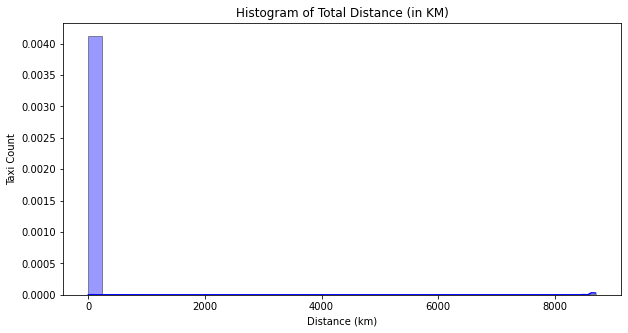

In [16]:
sns.distplot(taxi_data["Total Distance"], hist=True, kde=True, 
             bins=int(180/5), color = 'blue',
             hist_kws={'edgecolor':'black'})
plt.title('Histogram of Total Distance (in KM)')
plt.xlabel('Distance (km)')
plt.ylabel('Taxi Count')

In [17]:
quantile_trip_distance = taxi_data["Total Distance"].quantile(np.round(np.arange(0.00, 1.01, 0.1), 2))
qValues = np.round(np.arange(0.00, 1.01, 0.1), 2)
for i in qValues:
    print("{}th percentile value of Trip Distance is {} miles".format((int(i*100)), quantile_trip_distance[i]))

0th percentile value of Trip Distance is 0.0 miles
10th percentile value of Trip Distance is 0.7492709046867477 miles
20th percentile value of Trip Distance is 1.0673367204529007 miles
30th percentile value of Trip Distance is 1.36623419935185 miles
40th percentile value of Trip Distance is 1.6996171693652218 miles
50th percentile value of Trip Distance is 2.093946624214727 miles
60th percentile value of Trip Distance is 2.607686896995373 miles
70th percentile value of Trip Distance is 3.3500762058818854 miles
80th percentile value of Trip Distance is 4.64082863330223 miles
90th percentile value of Trip Distance is 7.573848505050393 miles
100th percentile value of Trip Distance is 8699.6815488446 miles


In [18]:
quantile_trip_distance = taxi_data["Total Distance"].quantile(np.round(np.arange(0.90, 1.01, 0.01), 2))
qValues = np.round(np.arange(0.90, 1.01, 0.01), 2)
for i in qValues:
    print("{}th percentile value of Trip Distance is {} miles".format((int(i*100)), quantile_trip_distance[i]))

90th percentile value of Trip Distance is 7.573848505050393 miles
91th percentile value of Trip Distance is 8.142816653366687 miles
92th percentile value of Trip Distance is 8.798956417051002 miles
93th percentile value of Trip Distance is 9.397158768550444 miles
94th percentile value of Trip Distance is 10.020972752632625 miles
95th percentile value of Trip Distance is 10.963335958713927 miles
96th percentile value of Trip Distance is 12.785275040588765 miles
97th percentile value of Trip Distance is 15.553568004006992 miles
98th percentile value of Trip Distance is 19.696153912818296 miles
99th percentile value of Trip Distance is 21.19148240087422 miles
100th percentile value of Trip Distance is 8699.6815488446 miles


In [19]:
quantile_trip_distance = taxi_data["Total Distance"].quantile(np.round(np.arange(0.991, 1.001, 0.001), 4))
qValues = np.round(np.arange(0.991, 1.001, 0.001), 4)
for i in qValues:
    print("{}th percentile value of Trip Distance is {} miles".format((float(i*100)), quantile_trip_distance[i]))

99.1th percentile value of Trip Distance is 21.379037970019215 miles
99.2th percentile value of Trip Distance is 21.553158049731305 miles
99.3th percentile value of Trip Distance is 21.890169352321486 miles
99.4th percentile value of Trip Distance is 22.249016250305527 miles
99.5th percentile value of Trip Distance is 23.10262631059412 miles
99.6th percentile value of Trip Distance is 27.204861362125055 miles
99.7th percentile value of Trip Distance is 8663.330723234401 miles
99.8th percentile value of Trip Distance is 8665.593828184054 miles
99.9th percentile value of Trip Distance is 8666.419946628994 miles
100.0th percentile value of Trip Distance is 8699.6815488446 miles


In [20]:
# Removing the outlier points from the dataset

taxi_data = taxi_data[taxi_data["Total Distance"] <= 24]

Text(0, 0.5, 'Taxi Count')

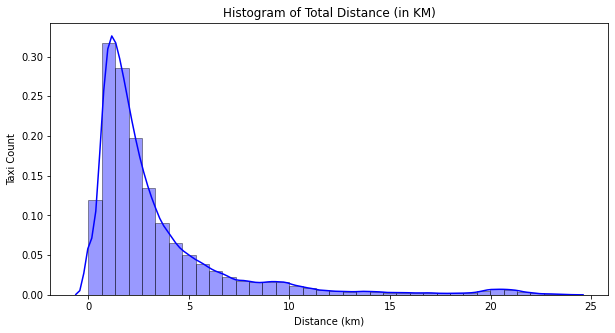

In [21]:
sns.distplot(taxi_data["Total Distance"], hist=True, kde=True, 
             bins=int(180/5), color = 'blue',
             hist_kws={'edgecolor':'black'})
plt.title('Histogram of Total Distance (in KM)')
plt.xlabel('Distance (km)')
plt.ylabel('Taxi Count')

Text(0, 0.5, 'Count')

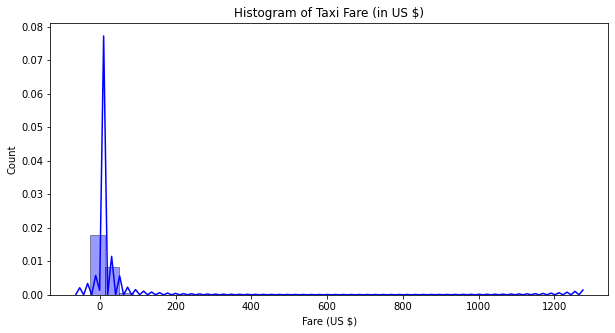

In [22]:
sns.distplot(taxi_data["fare_amount"], hist=True, kde=True, 
             bins=int(180/5), color = 'blue',
             hist_kws={'edgecolor':'black'})
plt.title('Histogram of Taxi Fare (in US $)')
plt.xlabel('Fare (US $)')
plt.ylabel('Count')

In [23]:
taxi_data["Weekday"].value_counts()

0    71968
1    27543
Name: Weekday, dtype: int64

### Feature Selectivalue_counts

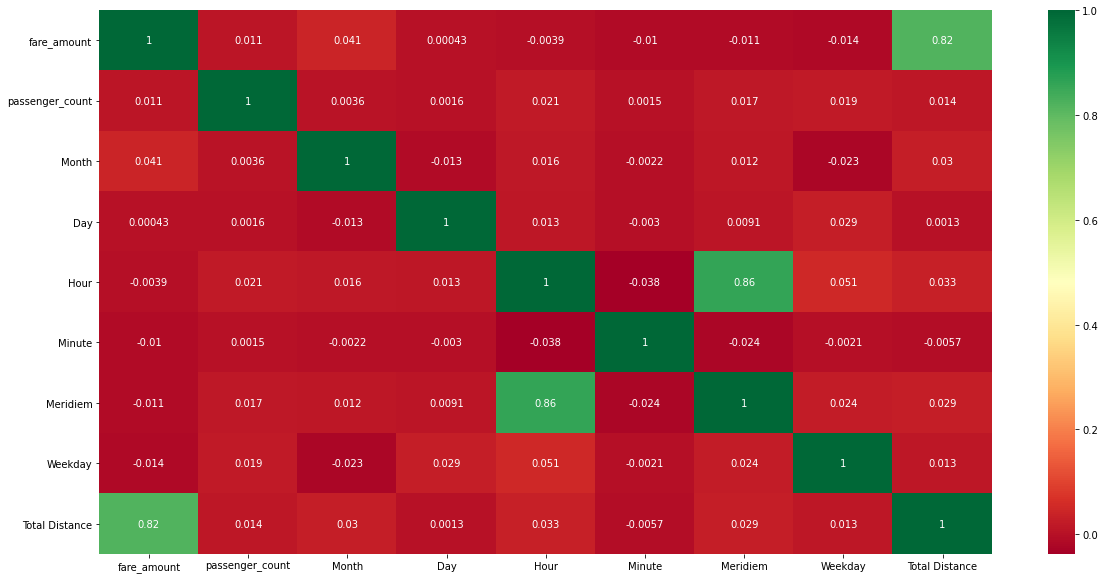

In [24]:
#Finding the correlation

plt.figure(figsize = (20,10))
sns.heatmap(taxi_data.corr(), annot = True, cmap = "RdYlGn")
plt.show()

### Data Preparation for ML Algos

In [25]:
X, y = taxi_data.iloc[:, 1:], taxi_data.iloc[:, 0]  

In [26]:
from sklearn.ensemble import ExtraTreesRegressor

model = ExtraTreesRegressor()
model.fit(X, y)

ExtraTreesRegressor(bootstrap=False, ccp_alpha=0.0, criterion='mse',
                    max_depth=None, max_features='auto', max_leaf_nodes=None,
                    max_samples=None, min_impurity_decrease=0.0,
                    min_impurity_split=None, min_samples_leaf=1,
                    min_samples_split=2, min_weight_fraction_leaf=0.0,
                    n_estimators=100, n_jobs=None, oob_score=False,
                    random_state=None, verbose=0, warm_start=False)

In [27]:
feature_importance = pd.Series(model.feature_importances_, index = X.columns)

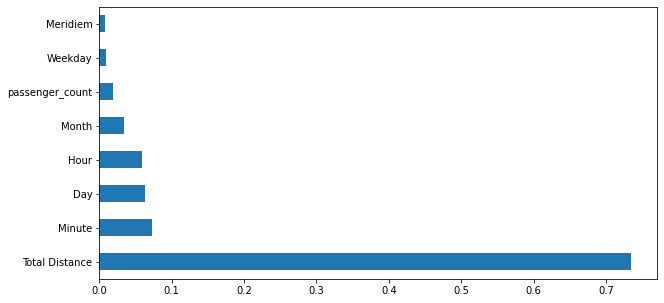

In [29]:
feature_importance.nlargest(10).plot(kind='barh')
plt.show()

Model Fitting

In [34]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso, SGDRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor

from sklearn import metrics
from sklearn.model_selection import GridSearchCV, ShuffleSplit, RandomizedSearchCV

np.set_printoptions(formatter={'float_kind':'{:f}'.format})

In [32]:
def fcnPrintErrorMetrics(y_test, y_pred):
    print('R2:', metrics.r2_score(y_test, y_pred))
    print('MAE:', metrics.mean_absolute_error(y_test, y_pred))
    print('MSE:', metrics.mean_squared_error(y_test, y_pred))
    print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
    sns.distplot(y_test - y_pred)

In [33]:
X_train, X_test, y_train, y_test = train_test_split(X.values, y.values, test_size = 0.2, random_state = 42)

R2: 0.6846334151218278
MAE: 2.650944307470221
MSE: 43.58217335552222
RMSE: 6.601679585947974


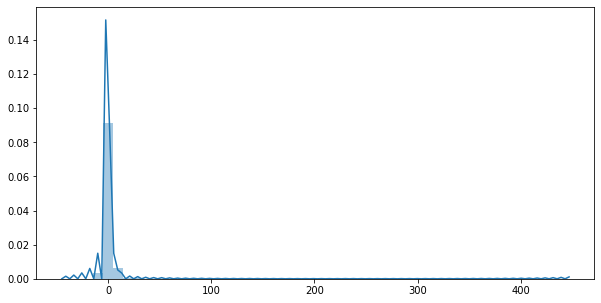

In [35]:
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)
y_pred = lin_reg.predict(X_test)

fcnPrintErrorMetrics(y_test, y_pred)

R2: 0.6683293768389049
MAE: 3.3346835887388626
MSE: 45.835314483698205
RMSE: 6.770178319933546


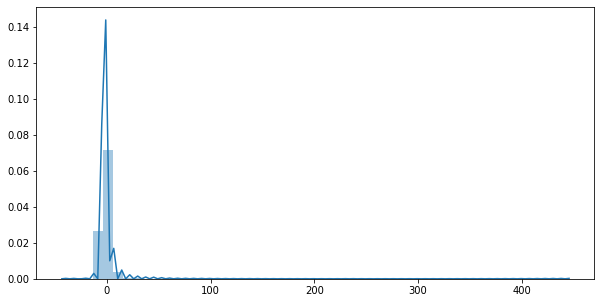

In [36]:
ln_reg = SGDRegressor()
ln_reg.fit(X_train, y_train)
y_pred2 = ln_reg.predict(X_test)

fcnPrintErrorMetrics(y_test, y_pred2)

R2: 0.6846366337063972
MAE: 2.6509139277365317
MSE: 43.58172856232792
RMSE: 6.60164589798089


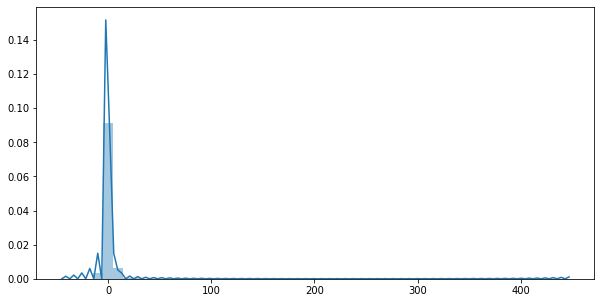

In [37]:
ridge = Ridge()
parameters = {'alpha':[1e-15,1e-10,1e-8,1e-3,1e-2,1,5,10,20,30,35,40]}
ridge_regressor = GridSearchCV(ridge, parameters, scoring='neg_mean_squared_error', cv=5)
ridge_regressor.fit(X_train, y_train)
y_pred2 = ridge_regressor.predict(X_test)

fcnPrintErrorMetrics(y_test, y_pred2)

R2: 0.6846366337063972
MAE: 2.6509139277365317
MSE: 43.58172856232792
RMSE: 6.60164589798089


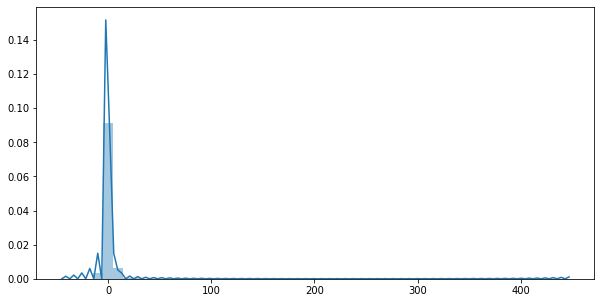

In [38]:
lasso = Lasso()
parameters = {'alpha':[1e-15,1e-10,1e-8,1e-3,1e-2,1,5,10,20,30,35,40]}
lasso_regressor = GridSearchCV(lasso, parameters, scoring='neg_mean_squared_error', cv=5)
lasso_regressor.fit(X_train,y_train)
y_pred3 = ridge_regressor.predict(X_test)

fcnPrintErrorMetrics(y_test, y_pred3)

R2: 0.5344536211283694
MAE: 3.4693809978395214
MSE: 64.33631196804501
RMSE: 8.020991956612662


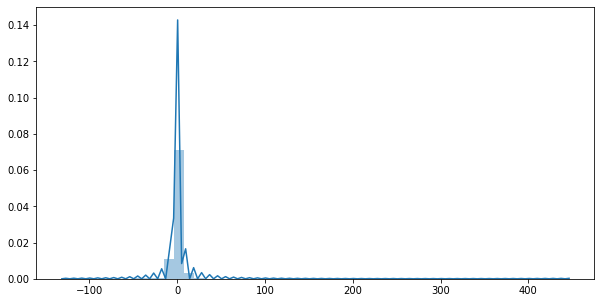

In [39]:
dt_reg = DecisionTreeRegressor()
dt_reg.fit(X_train, y_train)
dt_reg.score(X_test, y_test)
y_pred4 = dt_reg.predict(X_test)

fcnPrintErrorMetrics(y_test, y_pred4)

R2: 0.6995568784927506
MAE: 2.5590623953555696
MSE: 41.519821163239094
RMSE: 6.443587600338735


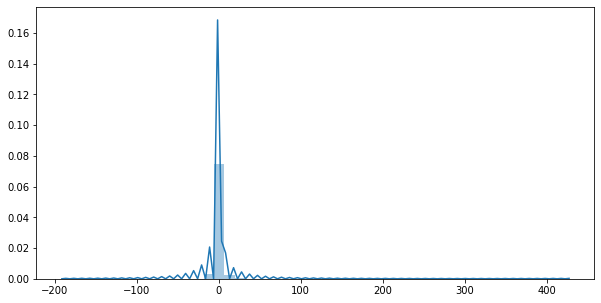

In [40]:
rf_reg = RandomForestRegressor()
rf_reg.fit(X_train, y_train)
rf_reg.score(X_test, y_test)
y_pred5 = rf_reg.predict(X_test)

fcnPrintErrorMetrics(y_test, y_pred5)

R2: 0.364799798394995
MAE: 3.75200789778082
MSE: 87.7816694260942
RMSE: 9.369187234018446


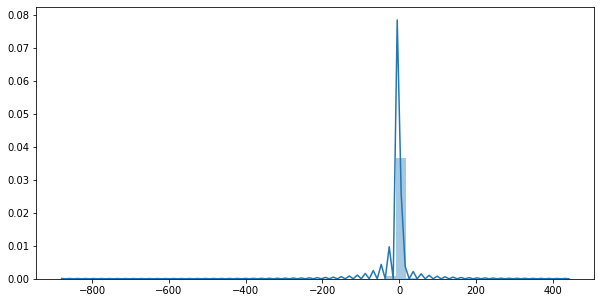

In [41]:
ab_reg = AdaBoostRegressor(loss = "linear")
ab_reg.fit(X_train, y_train)
ab_reg.score(X_test, y_test)
y_pred6 = ab_reg.predict(X_test)

fcnPrintErrorMetrics(y_test, y_pred6)

R2: 0.7211157968577568
MAE: 2.4361839861344414
MSE: 38.540480413158605
RMSE: 6.2080979706475805


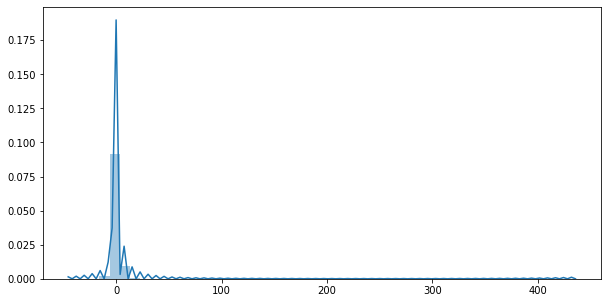

In [42]:
gb_reg = GradientBoostingRegressor(max_depth = 7, max_features = 4, n_estimators = 35)
gb_reg.fit(X_train, y_train)
gb_reg.score(X_test, y_test)
y_pred7 = gb_reg.predict(X_test)

fcnPrintErrorMetrics(y_test, y_pred7)

[05:13:20] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
R2: 0.7237958914253302
MAE: 2.4004408458661226
MSE: 38.170103995193166
RMSE: 6.178195852770707


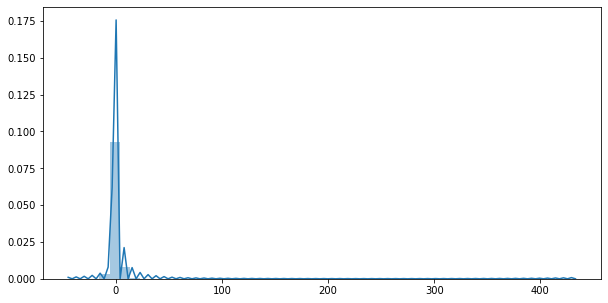

In [43]:
xgb_reg = XGBRegressor()
xgb_reg.fit(X_train, y_train)
xgb_reg.score(X_test, y_test)
y_pred8 = xgb_reg.predict(X_test)

fcnPrintErrorMetrics(y_test, y_pred8)

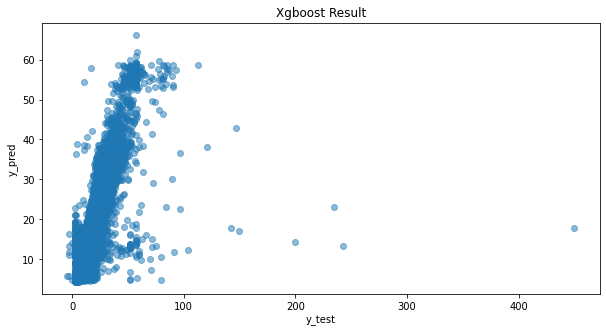

In [46]:
plt.scatter(y_test, y_pred8, alpha = 0.5)
plt.xlabel("y_test")
plt.ylabel("y_pred")
plt.title("Xgboost Result")
plt.show()

In [47]:
def find_best_model(X, y):
    algos = {
        'xgboost': {
            'model': XGBRegressor(),
            'params': {
                'n_estimators': [100, 200, 300],
                'reg_alpha':[0.005, 0.01, 0.05],
                'gamma':[i/10.0 for i in range(0,5)],
                'min_child_weight':[6,8,10,12],
                'max_depth':[4,5,6]
            }
        }

    }
    
    scores = []
    cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)
    for algo_name, config in algos.items():
        gs =  RandomizedSearchCV(config['model'], config['params'], cv=cv, return_train_score=False)
        gs.fit(X,y)
        scores.append({
            'model': algo_name,
            'best_score': gs.best_score_,
            'best_params': gs.best_params_
        })

    return pd.DataFrame(scores,columns=['model','best_score','best_params'])


model_scores = find_best_model(X.values, y.values)
model_scores

[05:16:51] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:16:59] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:17:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:17:16] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:17:24] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:17:33] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:17:39] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:17:46] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

,model,best_score,best_params
0,xgboost,0.758233,"{'reg_alpha': 0.005, 'n_estimators': 100, 'min..."


In [49]:
model_scores["best_params"][0]

{'gamma': 0.0,
 'max_depth': 4,
 'min_child_weight': 10,
 'n_estimators': 100,
 'reg_alpha': 0.005}

[05:45:38] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
R2: 0.7279116275691435
MAE: 2.3362860344162844
MSE: 37.899935168055485
RMSE: 6.156292323148365


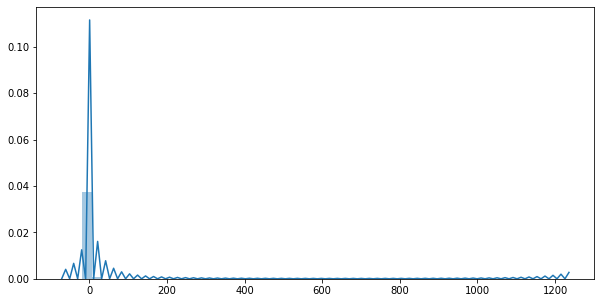

In [50]:
# Since Xgboost gives us the best results, it is selected as the final model

xgb_reg = XGBRegressor(gamma=0.0,max_depth=4, min_child_weight=10, n_estimators=100, reg_alpha=0.005)
xgb_reg.fit(X.values, y.values)
xgb_reg.score(X.values, y.values)
y_pred_f = xgb_reg.predict(X.values)

fcnPrintErrorMetrics(y.values, y_pred_f)

In [51]:
import pickle
import json

In [52]:
with open('ny_taxi_fare.pickle','wb') as f:
    pickle.dump(xgb_reg, f)

In [54]:
cat_feature_columns = {
    "data_columns" : ["passenger_count", "Month", "Day", "Hour", "Minute", "Meridiem", "Weekday", "Total Distance"]
}

with open("columns.json", "w") as f:
    f.write(json.dumps(cat_feature_columns))